In [15]:
import pandas as pd
import numpy as np
# load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import StratifiedGroupKFold,StratifiedShuffleSplit,KFold,train_test_split
from xgboost import XGBRegressor
from tqdm import tqdm

In [ ]:
#data
train=pd.read_csv("../dataset/train_features.csv")
y=pd.read_csv("../dataset/train_labels.csv")
test=pd.read_csv("../dataset/test_features.csv")
ss=pd.read_csv("../dataset/submission_format.csv")

In [3]:
train.head(2)

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,aace,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.somewhat important,9.Never,9.Never,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2
1,aanz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,1.Almost every day,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2


In [4]:
test.head(2)

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,abxu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Wood, mosaic, or other covering 1"
1,aeol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,9.Never,1.Yes,NaN,NaN,NaN,NaN,NaN,Concrete 2


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Columns: 184 entries, uid to j11_12
dtypes: float64(140), object(44)
memory usage: 4.6+ MB


In [6]:
#let merge train and label
merged_df = pd.merge(train, y, on='uid', how='left')

In [7]:
#so many missing values
merged_df.isnull().sum()

uid                   0
age_03             1456
urban_03           1454
married_03         1454
n_mar_03           1482
                   ... 
a33b_12            4288
a34_12             1601
j11_12               89
year                  0
composite_score       0
Length: 186, dtype: int64

In [8]:
#lets merged test AND sample submission
merged_test = pd.merge(test, ss, on='uid', how='left')

<Axes: title={'center': 'Target Distribution'}, ylabel='Frequency'>

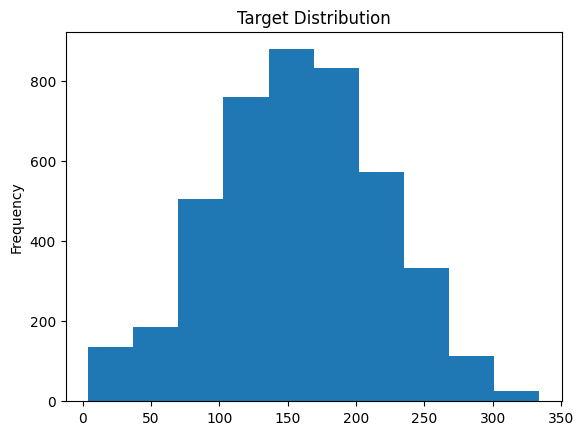

In [9]:
merged_df['composite_score'].plot(kind='hist',title='Target Distribution')

In [10]:
y=merged_df['composite_score']
data=pd.concat((merged_df,merged_test)).reset_index(drop=True).copy()
data=data.drop(columns=['uid','year','composite_score'],axis=1)

In [11]:
# Get the columns with object datatype
object_cols = data.select_dtypes(include=['object']).columns

# Convert the object columns to category dtype
for col in object_cols:
    #data[col] = data[col].astype('category').fillna("Missing")
    data[col] = pd.Categorical(data[col].fillna("Missing"))

In [12]:
#separate train and test
merged_df=data[:len(merged_df)]
merged_test=data[len(merged_df):]

In [13]:
merged_df.shape

(4343, 183)

In [31]:
# Define the number of folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Placeholder for storing results
fold_results = []

for train_index, val_index in tqdm(kf.split(merged_df)):
    # Split the data
    train_X, val_X = merged_df.iloc[train_index], merged_df.iloc[val_index]
    train_y, val_y = y.iloc[train_index], y.iloc[val_index]

    # Train CatBoost
    model = XGBRegressor(n_estimators=10000, learning_rate=0.01,
                         max_depth=3, random_state=42, 
                         enable_categorical=True,
                         eval_metric=root_mean_squared_error,
                         early_stopping_rounds=500)
    model.fit(train_X, train_y, eval_set=[(val_X, val_y)], verbose=100)
    pred = model.predict(val_X)

    # Combine predictions using optimized weights
    final_predictions = pred

    # Store results
    fold_mse = root_mean_squared_error(val_y, final_predictions) # np.mean((final_predictions - val_y) ** 2)
    fold_results.append(fold_mse)

# Display results
print(f"Average MSE across folds: {np.mean(fold_results)}")


0it [00:00, ?it/s]

[0]	validation_0-rmse:58.77700	validation_0-root_mean_squared_error:58.77700
[100]	validation_0-rmse:45.87150	validation_0-root_mean_squared_error:45.87149
[200]	validation_0-rmse:42.37062	validation_0-root_mean_squared_error:42.37062
[300]	validation_0-rmse:40.86782	validation_0-root_mean_squared_error:40.86782
[400]	validation_0-rmse:40.11746	validation_0-root_mean_squared_error:40.11746
[500]	validation_0-rmse:39.69761	validation_0-root_mean_squared_error:39.69761
[600]	validation_0-rmse:39.48058	validation_0-root_mean_squared_error:39.48059
[700]	validation_0-rmse:39.30701	validation_0-root_mean_squared_error:39.30701
[800]	validation_0-rmse:39.19555	validation_0-root_mean_squared_error:39.19555
[900]	validation_0-rmse:39.07754	validation_0-root_mean_squared_error:39.07754
[1000]	validation_0-rmse:38.99182	validation_0-root_mean_squared_error:38.99182
[1100]	validation_0-rmse:38.93534	validation_0-root_mean_squared_error:38.93534
[1200]	validation_0-rmse:38.88917	validation_0-root_

1it [00:13, 13.40s/it]

[0]	validation_0-rmse:63.17007	validation_0-root_mean_squared_error:63.17006
[100]	validation_0-rmse:47.39228	validation_0-root_mean_squared_error:47.39228
[200]	validation_0-rmse:42.63320	validation_0-root_mean_squared_error:42.63320
[300]	validation_0-rmse:40.82608	validation_0-root_mean_squared_error:40.82608
[400]	validation_0-rmse:39.94906	validation_0-root_mean_squared_error:39.94906
[500]	validation_0-rmse:39.51808	validation_0-root_mean_squared_error:39.51808
[600]	validation_0-rmse:39.24745	validation_0-root_mean_squared_error:39.24746
[700]	validation_0-rmse:39.06895	validation_0-root_mean_squared_error:39.06895
[800]	validation_0-rmse:38.89325	validation_0-root_mean_squared_error:38.89325
[900]	validation_0-rmse:38.78512	validation_0-root_mean_squared_error:38.78512
[1000]	validation_0-rmse:38.72266	validation_0-root_mean_squared_error:38.72266
[1100]	validation_0-rmse:38.63585	validation_0-root_mean_squared_error:38.63585
[1200]	validation_0-rmse:38.56887	validation_0-root_

2it [00:33, 17.31s/it]

[0]	validation_0-rmse:59.59052	validation_0-root_mean_squared_error:59.59052
[100]	validation_0-rmse:46.84483	validation_0-root_mean_squared_error:46.84483
[200]	validation_0-rmse:43.33925	validation_0-root_mean_squared_error:43.33925
[300]	validation_0-rmse:41.95577	validation_0-root_mean_squared_error:41.95577
[400]	validation_0-rmse:41.26072	validation_0-root_mean_squared_error:41.26072
[500]	validation_0-rmse:40.83577	validation_0-root_mean_squared_error:40.83577
[600]	validation_0-rmse:40.61516	validation_0-root_mean_squared_error:40.61516
[700]	validation_0-rmse:40.48206	validation_0-root_mean_squared_error:40.48206
[800]	validation_0-rmse:40.36532	validation_0-root_mean_squared_error:40.36532
[900]	validation_0-rmse:40.28179	validation_0-root_mean_squared_error:40.28179
[1000]	validation_0-rmse:40.21467	validation_0-root_mean_squared_error:40.21468
[1100]	validation_0-rmse:40.15193	validation_0-root_mean_squared_error:40.15193
[1200]	validation_0-rmse:40.10832	validation_0-root_

3it [00:49, 16.87s/it]

[0]	validation_0-rmse:60.77724	validation_0-root_mean_squared_error:60.77724
[100]	validation_0-rmse:46.89625	validation_0-root_mean_squared_error:46.89625
[200]	validation_0-rmse:43.13236	validation_0-root_mean_squared_error:43.13235
[300]	validation_0-rmse:41.60853	validation_0-root_mean_squared_error:41.60853
[400]	validation_0-rmse:40.78407	validation_0-root_mean_squared_error:40.78407
[500]	validation_0-rmse:40.24810	validation_0-root_mean_squared_error:40.24810
[600]	validation_0-rmse:39.95609	validation_0-root_mean_squared_error:39.95609
[700]	validation_0-rmse:39.75397	validation_0-root_mean_squared_error:39.75397
[800]	validation_0-rmse:39.61135	validation_0-root_mean_squared_error:39.61135
[900]	validation_0-rmse:39.50370	validation_0-root_mean_squared_error:39.50370
[1000]	validation_0-rmse:39.39980	validation_0-root_mean_squared_error:39.39980
[1100]	validation_0-rmse:39.27634	validation_0-root_mean_squared_error:39.27634
[1200]	validation_0-rmse:39.20299	validation_0-root_

4it [01:17, 21.10s/it]

[0]	validation_0-rmse:60.80225	validation_0-root_mean_squared_error:60.80225
[100]	validation_0-rmse:48.18373	validation_0-root_mean_squared_error:48.18373
[200]	validation_0-rmse:44.82792	validation_0-root_mean_squared_error:44.82793
[300]	validation_0-rmse:43.47826	validation_0-root_mean_squared_error:43.47826
[400]	validation_0-rmse:42.88258	validation_0-root_mean_squared_error:42.88258
[500]	validation_0-rmse:42.60233	validation_0-root_mean_squared_error:42.60233
[600]	validation_0-rmse:42.42929	validation_0-root_mean_squared_error:42.42929
[700]	validation_0-rmse:42.34536	validation_0-root_mean_squared_error:42.34536
[800]	validation_0-rmse:42.29546	validation_0-root_mean_squared_error:42.29546
[900]	validation_0-rmse:42.25160	validation_0-root_mean_squared_error:42.25160
[1000]	validation_0-rmse:42.21009	validation_0-root_mean_squared_error:42.21009
[1100]	validation_0-rmse:42.16620	validation_0-root_mean_squared_error:42.16620
[1200]	validation_0-rmse:42.12253	validation_0-root_

5it [01:30, 18.16s/it]

Average MSE across folds: 39.04553779342417


In [ ]:
# Train models on the entire training dataset
model = XGBRegressor(n_estimators=10000, learning_rate=0.01,
                     max_depth=3, random_state=42, 
                    enable_categorical=True,
                    eval_metric=root_mean_squared_error,
                    early_stopping_rounds=500)
model.fit(merged_df, y)

# Generate predictions on the test dataset
pred = model.predict(merged_test)

# Optionally round predictions if required (e.g., for classification tasks)
final_test_predictions = np.round(pred).astype(int)

# Display final predictions
print("Final blended predictions for the test dataset:")
print(final_test_predictions)

ss['composite_score']=final_test_predictions
#generate submission
ss.to_csv('../dataset/trainXGBoosrv2.csv', index=False)